## Import Libraries

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR


## Define the constants and initial conditions

In [2]:
# Geometry
length = 15.0e-3             # Length of the rod

# Material properties
rho = 2300.0                     # Density of AL380 (kg/m^3)
rho_l = 2460.0                   # Density of AL380 (kg/m^3)
rho_s = 2710.0                    # Density of AL380 (kg/m^3)
rho_m = (rho_l + rho_s )/2       # Desnity in mushy zone is taken as average of liquid and solid density

k = 104.0                       # W/m-K
k_l = k                       # W/m-K
k_s = 96.2                    # W/m-K
k_m =  (k_l+k_s)/2                     # W/m-K
k_mo = 41.5


cp = 1245.3                      # Specific heat of aluminum (J/kg-K)
cp_l = cp                      # Specific heat of aluminum (J/kg-K)
cp_s = 963.0                 # Specific heat of aluminum (J/kg-K)
cp_m =  (cp_l+cp_s)/2                 # Specific heat of mushy zone is taken as average of liquid and solid specific heat
# cp_m = cp
           # Thermal diffusivity
alpha_l = k_l / (rho_l * cp_l) 
alpha_s = k_s / (rho_s*cp_s)
alpha_m = k_m / (rho_m * cp_m)          #`Thermal diffusivity in mushy zone is taken as average of liquid and solid thermal diffusivity`


#L_fusion = 3.9e3                 # J/kg
L_fusion = 389.0e3               # J/kg  # Latent heat of fusion of aluminum
         # Thermal diffusivity


T_L = 574.4 +273.0                       #  K -Liquidus Temperature (615 c) AL 380
T_S = 497.3 +273.0                     # K- Solidus Temperature (550 C)
m_eff =(k_m/(rho_m*(cp_m + (L_fusion/(T_L-T_S)))))
print (f"alpha_l = {alpha_l}, alpha_s = {alpha_s}, m_eff = {m_eff}")

# htc = 10.0                   # W/m^2-K
# q = htc*(919.0-723.0)
# q = 10000.0


num_points = 50                        # Number of spatial points
dx = length / (num_points - 1)         # Distance between two spatial points
print('dx is',dx)

                                                              
# Time Discretization  
# 
time_end = 12        # seconds                         

maxi = max(alpha_s,alpha_l,alpha_m)
dt = abs(0.5*((dx**2) /maxi)) 

print('dt is ',dt)
num_steps = round(time_end/dt)
print('num_steps is',num_steps)
cfl = 0.5 *(dx**2/max(alpha_l,alpha_s,alpha_m))
print('cfl is',cfl)

time_steps = np.linspace(0, time_end, num_steps + 1)
step_coeff = dt / (dx ** 2)

if dt <= cfl:
    print('stability criteria satisfied')
else:
    print('stability criteria not satisfied')
    sys.exit()

alpha_l = 3.394878564540885e-05, alpha_s = 3.686205086349929e-05, m_eff = 6.296953764744878e-06
dx is 0.0003061224489795918
dt is  0.0012711033647622566
num_steps is 9441
cfl is 0.0012711033647622566
stability criteria satisfied


Defining the simulation field and initilisation of the temperatures

In [3]:


# Initial temperature and phase fields
temperature = np.full(num_points+2, 919.0)            # Initial temperature of the rod with ghost points at both ends
phase = np.zeros(num_points+2)*0.0                    # Initial phase of the rod with ghost points at both ends

# Set boundary conditions
# temperature[-1] = 919.0 
phase[-1] = 1.0

# temperature[0] = 919.0 #(40 C)
phase[0] = 1.0

# Store initial state in history
temperature_history = [temperature.copy()]    # List to store temperature at each time step
phi_history = [phase.copy()]                    # List to store phase at each time step
temp_init = temperature.copy()                 # Initial temperature of the rod
# print(temperature_history,phi_history)
# Array to store temperature at midpoint over time
midpoint_index = num_points // 2                          # Index of the midpoint

midpoint_temperature_history = [temperature[midpoint_index]]            # List to store temperature at midpoint over time
dm = 60.0e-3                                                            # die thickness in m

# r_m =  (k_mo / dm) + (1/htc)

t_surr = 500.0                                        # Surrounding temperature in K
# t_surr = h()

def kramp(temp,v1,v2,T_L,T_s):                                      # Function to calculate thermal conductivity in Mushy Zone
        slope = (v1-v2)/(T_L-T_S)
        if temp > T_L:
            k_m = k_l
        elif temp < T_S:
            k_m = k_s
        else:
            k_m = k_s + slope*(temp-T_S)
        return k_m

def cp_ramp(temp,v1,v2,T_L,T_s):                                    # Function to calculate specific heat capacity in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        cp_m = cp_l
    elif temp < T_S:
        cp_m = cp_s
    else:
        cp_m = cp_s + slope*(temp-T_S)
    return cp_m

def rho_ramp(temp,v1,v2,T_L,T_s):                                       # Function to calculate density in Mushy Zone
    slope = (v1-v2)/(T_L-T_S)
    if temp > T_L:
        rho_m = rho_l
    elif temp < T_S:
        rho_m = rho_s
    else:
        rho_m = rho_s + slope*(temp-T_S)
    return rho_m

Solving the heat transfer equation and phase change using numerical methods

In [4]:

for m in range(1, num_steps+1):                                                                            # time loop
    htc = 10.0                   # htc of Still air in W/m^2-K
    q1 = htc*(temp_init[0]-t_surr)   # Heat flux at the left boundary
    
    # print(f"q1 is {q1}")
    temperature[0] = temp_init[0] + alpha_l * step_coeff * ((2.0*temp_init[1]) - (2.0 * temp_init[0])-(2.0*dx*(q1)))  # Update boundary condition temperature
    
    q2 = htc*(temp_init[-1]-t_surr)                   # Heat flux at the right boundary
    temperature[-1] = temp_init[-1] + alpha_l * step_coeff * ((2.0*temp_init[-2]) - (2.0 * temp_init[-1])-(2.0*dx*(q2)))  # Update boundary condition temperature
    
    for n in range(1,num_points+1):              # space loop, adjusted range
       
        temperature[n] = temp_init[n] +((alpha_l * step_coeff) * (temp_init[n+1] - (2.0 * temp_init[n]) + temp_init[n-1]))
       
            
        

     
          
    temperature = temperature.copy()                                                                # Update temperature
    phase = phase.copy()                                                                            # Update phase
    temp_init = temperature.copy()                                                                  # Update last time step temperature
    temperature_history.append(temperature.copy())                                                  # Append the temperature history to add ghost points
    phi_history.append(phase.copy())                                                                # Append the phase history to add ghost points
    midpoint_temperature_history.append(temperature[midpoint_index])                                # Store midpoint temperature
    
    
    # print(f"Step {m}, Temperature: {temperature}")
    


# print(midpoint_temperature_history)
#print(phi_history)





(9442, 50)
50 9442


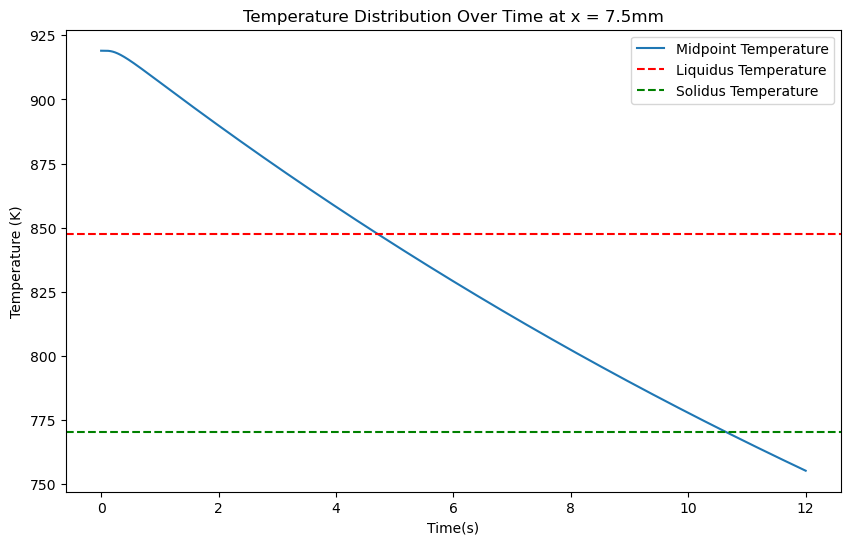

In [5]:
# Plot temperature history for debugging
aa = np.array(temperature_history)
temp_hist_l = aa[:,1:-1]
print(temp_hist_l.shape)
t_dim,x_dim  = temp_hist_l.shape
print(x_dim,t_dim)
time_ss= np.linspace(0, time_end, num_steps+1)
# print(time_ss.shape)
plt.figure(figsize=(10, 6))
plt.plot(time_ss, midpoint_temperature_history, label='Midpoint Temperature')
plt.axhline(y=T_L, color='r', linestyle='--', label='Liquidus Temperature')
plt.axhline(y=T_S, color='g', linestyle='--', label='Solidus Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution Over Time at x = 7.5mm') 
plt.legend()
plt.show()

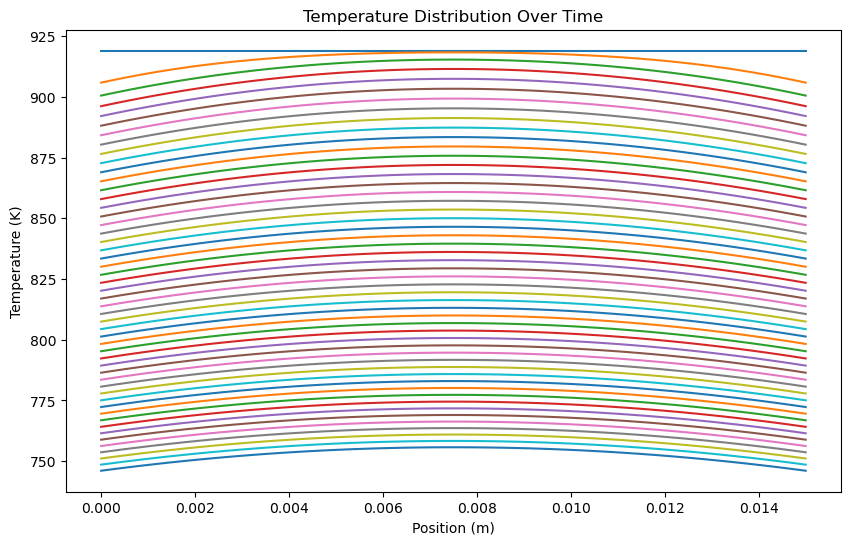

In [6]:
# Plot temperature history for debugging
plt.figure(figsize=(10, 6))
for i in range(0, num_steps, num_steps // 50):
    plt.plot(np.linspace(0, length, num_points+2), temperature_history[i], label=f't={i * dt:.2f} s')

plt.xlabel('Position (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature Distribution Over Time')
# plt.legend()
plt.show()

Plot the Results

Temperature History Shape: (9442, 52)
Phi History Shape: (9442, 52)
Transposed Temperature History Shape: (9442, 52)
Transposed Phi History Shape: (9442, 52)


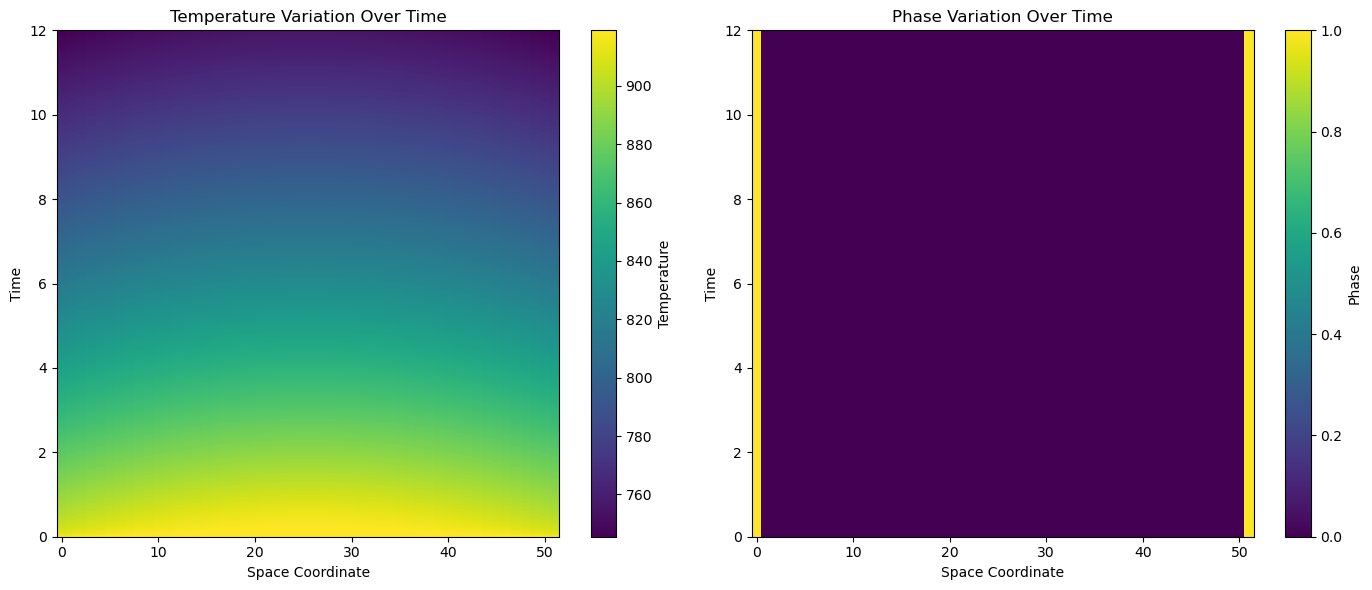

In [7]:
# Assuming you have temperature_history and phi_history as lists of arrays
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)

# Check the shape of temperature_history and phi_history
print("Temperature History Shape:", temperature_history.shape)
print("Phi History Shape:", phi_history.shape)

# Check the new shape after transposing
print("Transposed Temperature History Shape:", temperature_history.shape)
print("Transposed Phi History Shape:", phi_history.shape)

# Create a meshgrid for space and time coordinates
space_coord, time_coord = np.meshgrid(np.arange(temperature_history.shape[1]), np.arange(temperature_history.shape[0]))
time_coord = time_coord * dt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, temperature_history, cmap='viridis')
ax1.set_xlabel('Space Coordinate')
ax1.set_ylabel('Time')
ax1.set_title('Temperature Variation Over Time')
fig.colorbar(im1, ax=ax1, label='Temperature')

# Plot the phase history on the right subplot
im2 = ax2.pcolormesh(space_coord, time_coord, phi_history, cmap='viridis')
ax2.set_xlabel('Space Coordinate')
ax2.set_ylabel('Time')
ax2.set_title('Phase Variation Over Time')
fig.colorbar(im2, ax=ax2, label='Phase')
plt.tight_layout()
plt.show()

In [8]:
temperature_history = np.array(temperature_history)
phi_history = np.array(phi_history)
# print(temperature_history.shape)
# print(phi_history)

## SVR Training 

### Scale the data